In [1]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma

/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 定义先验分布
def prior_fun(batch_size=1):
    # N(mean, stddev)
    mean, stddev = 0.0, 1.0
    miu_dist = tfp.distributions.Normal(loc=mean, scale=stddev)
    miu_samples = miu_dist.sample(batch_size)

    # InverseGamma(alpha, beta)
    alpha, beta = 2.0, 1.0
    sigma2_dist = tfp.distributions.InverseGamma(concentration=alpha, scale=beta)
    sigma2_samples = sigma2_dist.sample(batch_size)

    # (batch_size, 2)
    return tf.stack([miu_samples, sigma2_samples], axis=-1)


def likelihood_fun(params, n_obs=1000):
    miu = params[:, 0]  #  miu
    sigma2 = params[:, 1]  # sigma^2
    return tf.random.normal(
        shape=(params.shape[0], n_obs, 1),
        mean=miu[:, None],
        stddev=tf.sqrt(sigma2)[:, None]
    )

In [3]:
prior = bf.simulation.Prior(prior_fun=prior_fun)
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

summary_net = bf.networks.DeepSet(summary_dim=10)

inference_net = bf.networks.InvertibleNetwork(
    num_params=2,
    num_coupling_layers=4,
)

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

# online learning
history = trainer.train_online(
    epochs=5,               # 10 epoch
    iterations_per_epoch=500,  
    batch_size=32,          
    validation_sims=200   
)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 1000, 1)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [01:16<00:00,  6.55it/s, Epoch: 1, Iter: 500,Loss: -2.568,W.Decay: 0.151,Avg.Loss: 0.281,Avg.W.Decay: 0.161,LR: 4.52E-04]
INFO:root:Validation, Epoch: 1, Loss: -2.723
Training epoch 2: 100%|██████████| 500/500 [01:12<00:00,  6.91it/s, Epoch: 2, Iter: 500,Loss: -3.122,W.Decay: 0.144,Avg.Loss: -2.779,Avg.W.Decay: 0.147,LR: 3.28E-04]
INFO:r

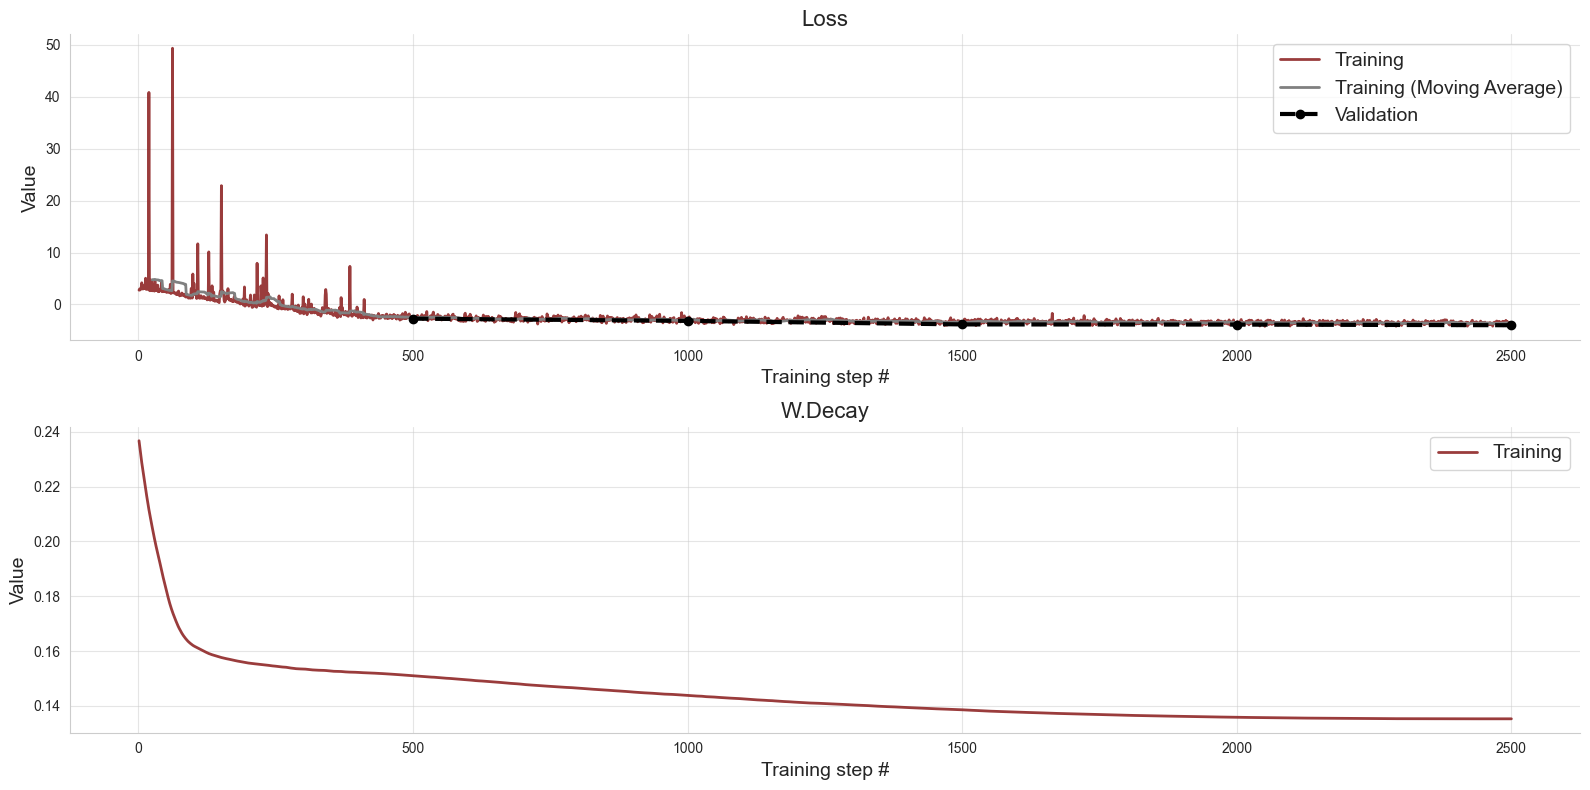

In [4]:

f = bf.diagnostics.plot_losses(
    history["train_losses"], 
    history["val_losses"], 
    moving_average=True
)

Summary vector shape:  (1, 1000, 10)
Posterior samples shape:  (1000, 2)


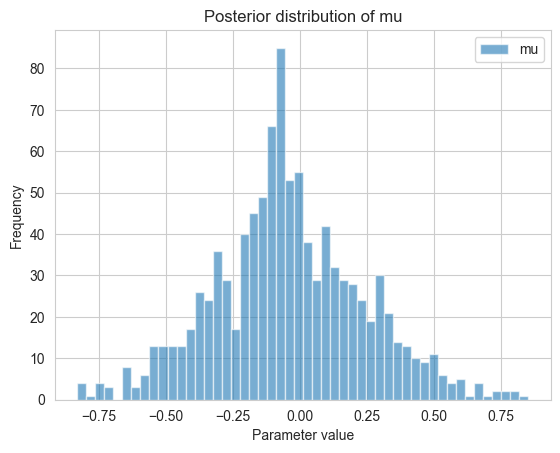

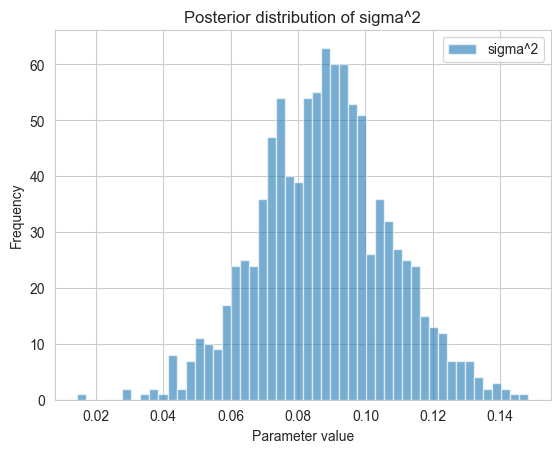

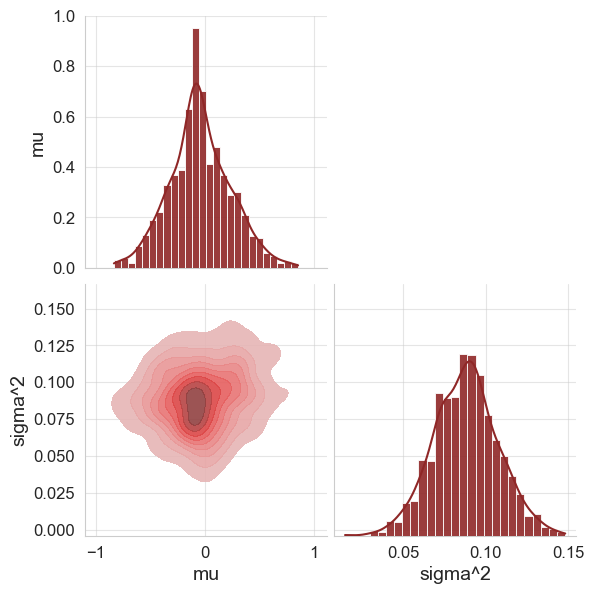

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Generate test data
n_obs = 1000  # Number of samples
true_miu = 0  # True mean
true_sigma = 0.3  # True standard deviation
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # Remember the value of Z, it will be used later
obs_data = obs_data[np.newaxis, :, :]  # Reshape to (1, n_obs, 1)

# 2. Use the summary network to extract features from the observed data
# The summary network transforms the data into a fixed-length feature vector
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # Should output shape (1, summary_dim)

# Use the inference network to perform inference on the observed data
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)
print("Posterior samples shape: ", posterior_samples.shape)  # Should output shape (1000, 2)

# Parameter names
param_names = ["mu", "sigma^2"]

# Plot histograms of the posterior distribution for each parameter
for i in range(posterior_samples.shape[1]):  # Iterate over mu and sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()
x
# Use diagnostic tools to plot the joint posterior distribution
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [18]:
import numpy as np

# Prior parameters
mu_0 = 0
sigma_0_sq = 1  # Prior variance
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Sample mean and sample size
Y_mean = np.mean(Z)  # Sample mean
n = n_obs  # Sample size

# Calculate total sample variance
variance = np.sum((Z - Y_mean) ** 2)  # Total variance

kappa_0 = 1
kappa_n = kappa_0 + n

# Posterior parameter calculations
# Posterior for sigma^2
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# Posterior for mu
sigma_poster_sq = sigma_0_sq / (kappa_0 + n)  # Posterior variance
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # Posterior mean

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 44.230809636240565
Posterior mu (mean): -0.012759735191856827
Posterior sigma^2 (variance): 0.000999000999000999


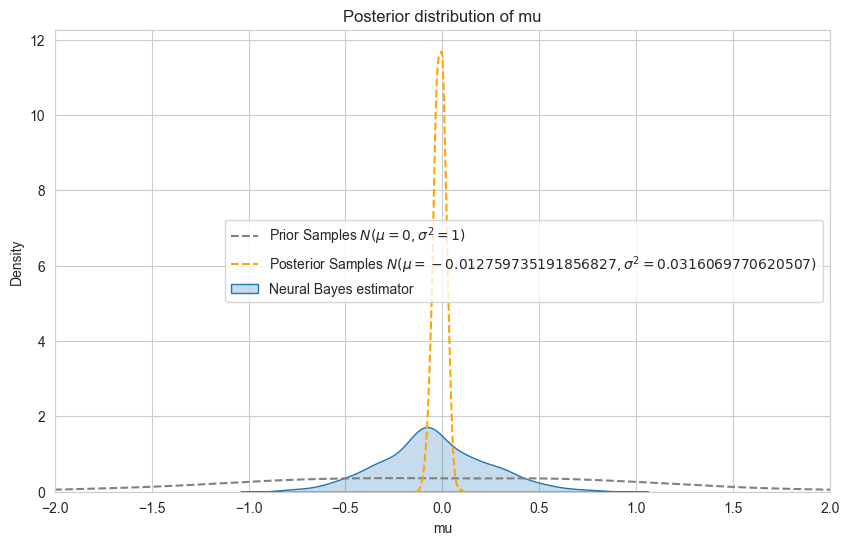

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
mu_prior = 0  # Mean
sigma_prior = 1  # Standard deviation

# Generate samples from the Prior distribution
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# Generate samples from the Posterior distribution
analytic_posterior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(analytic_posterior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange", linestyle="--")

# Set x-axis range
ax.set_xlim(-2, 2)


# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

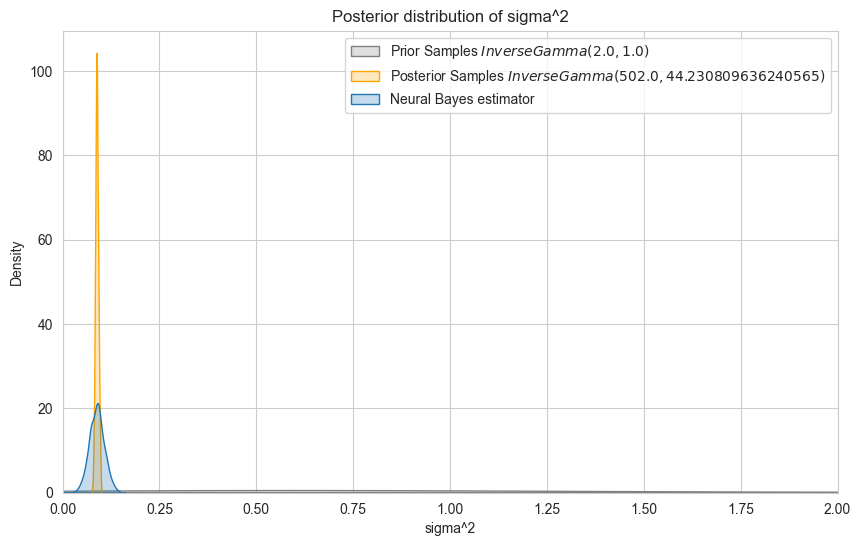

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
alpha_prior = 2.0  # Shape parameter α
beta_prior = 1.0   # Rate parameter β
# Convert to Inverse Gamma distribution samples
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")

# Convert to Inverse Gamma distribution samples for the posterior
analytic_posterior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(analytic_posterior_samples, ax=ax, fill=True, label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange")

# Set x-axis range
ax.set_xlim(0, 2)

param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()


Summary vector shape:  (1, 1000, 10)
Posterior samples shape:  (1000, 2)


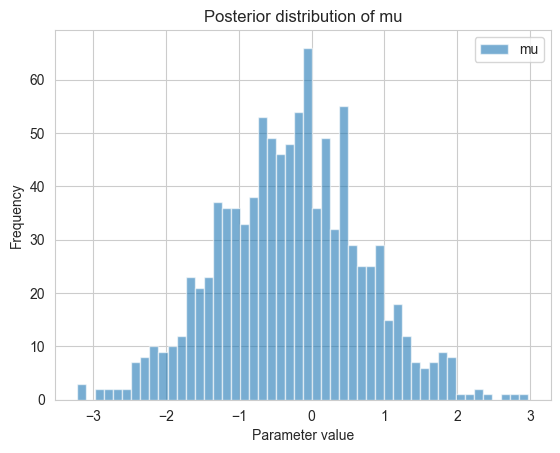

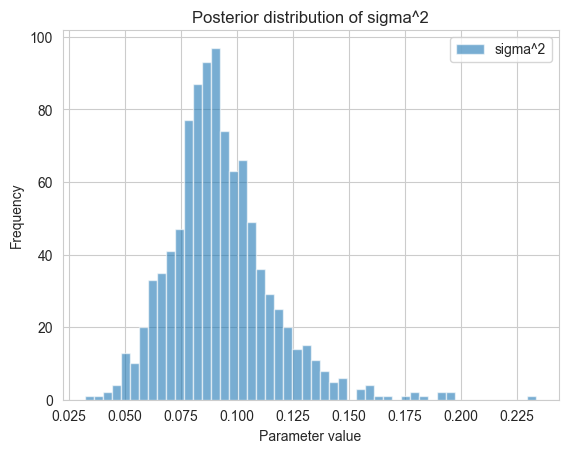

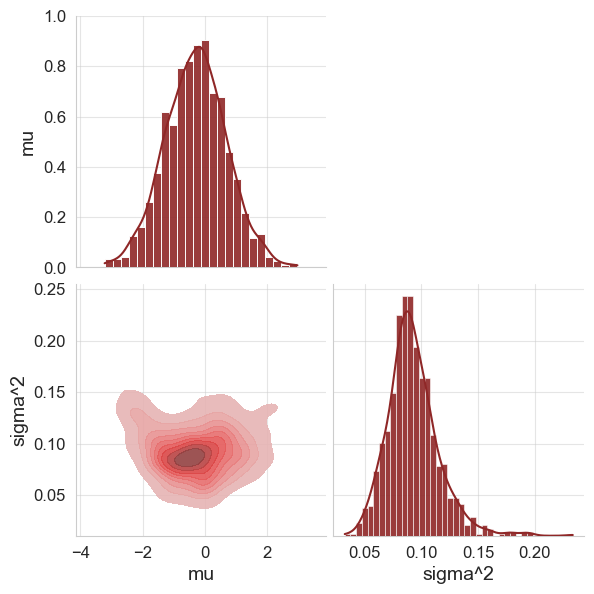

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Generate test data
n_obs = 1000  # Number of samples
true_miu = -0.3  # True mean
true_sigma = 1  # True standard deviation
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # Remember the value of Z, it will be used later
obs_data = obs_data[np.newaxis, :, :]  # Reshape to (1, n_obs, 1)

# 2. Use the summary network to extract features from the observed data
# The summary network transforms the data into a fixed-length feature vector
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # Should output shape (1, summary_dim)

# Use the inference network to perform inference on the observed data
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)
print("Posterior samples shape: ", posterior_samples.shape)  # Should output shape (1000, 2)

# Parameter names
param_names = ["mu", "sigma^2"]

# Plot histograms of the posterior distribution for each parameter
for i in range(posterior_samples.shape[1]):  # Iterate over mu and sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()
x
# Use diagnostic tools to plot the joint posterior distribution
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [24]:
import numpy as np

# Prior parameters
mu_0 = 0
sigma_0_sq = 1  # Prior variance
alpha_0 = 2
beta_0 = 1  # Prior scale parameter

# Sample mean and sample size
Y_mean = np.mean(Z)  # Sample mean
n = n_obs  # Sample size

# Calculate total sample variance
variance = np.sum((Z - Y_mean) ** 2)  # Total variance

kappa_0 = 1
kappa_n = kappa_0 + n

# Posterior parameter calculations
# Posterior for sigma^2
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# Posterior for mu
sigma_poster_sq = sigma_0_sq / (kappa_0 + n)  # Posterior variance
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # Posterior mean

# Output results
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 502.0
Posterior beta: 526.9719503160442
Posterior mu (mean): -0.28636030383876987
Posterior sigma^2 (variance): 0.000999000999000999


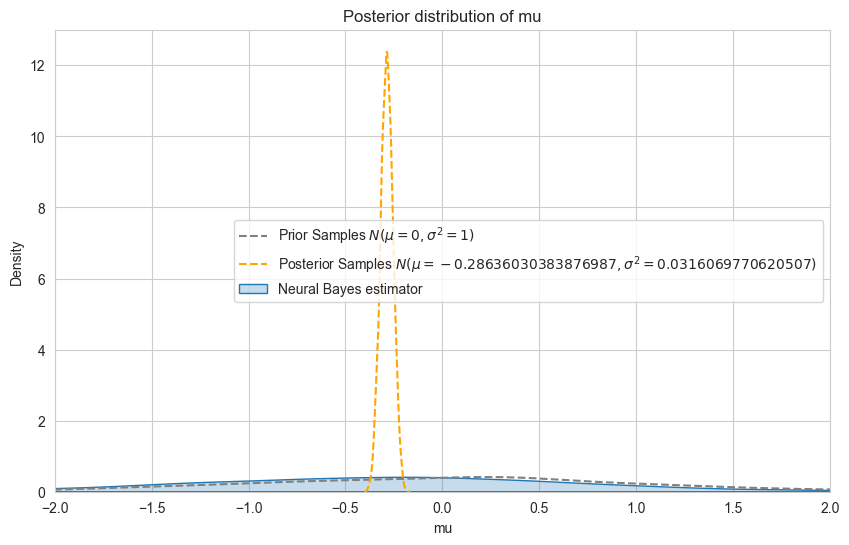

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
mu_prior = 0  # Mean
sigma_prior = 1  # Standard deviation

# Generate samples from the Prior distribution
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# Generate samples from the Posterior distribution
analytic_posterior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(analytic_posterior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange", linestyle="--")

# Set x-axis range
ax.set_xlim(-2, 2)


# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

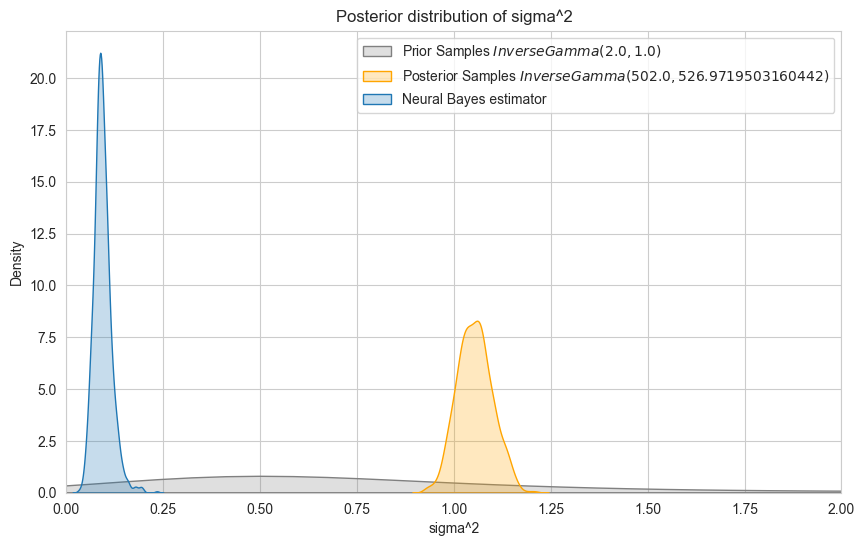

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
alpha_prior = 2.0  # Shape parameter α
beta_prior = 1.0   # Rate parameter β
# Convert to Inverse Gamma distribution samples
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")

# Convert to Inverse Gamma distribution samples for the posterior
analytic_posterior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(analytic_posterior_samples, ax=ax, fill=True, label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange")

# Set x-axis range
ax.set_xlim(0, 2)

param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()


Summary vector shape:  (1, 1000, 10)
Posterior samples shape:  (1000, 2)


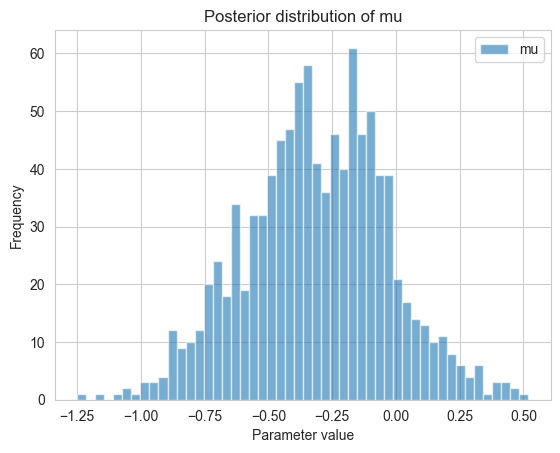

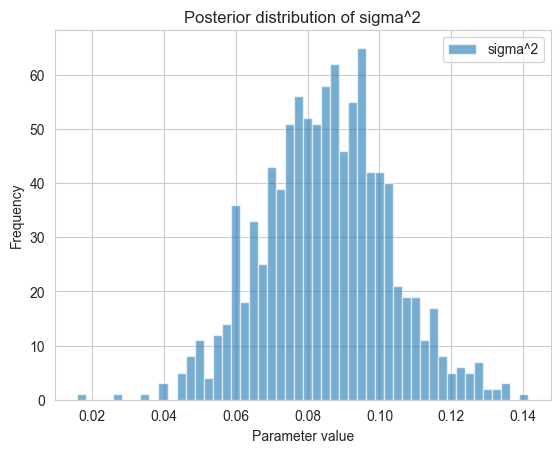

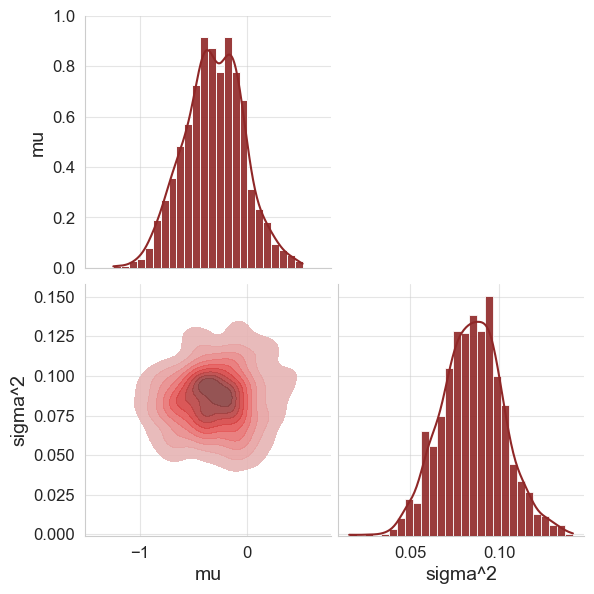

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Generate test data
n_obs = 1000  # Number of samples
true_miu = -0.3  # True mean
true_sigma = 0.3  # True standard deviation
obs_data = np.random.normal(loc=true_miu, scale=true_sigma, size=(n_obs, 1)).astype(np.float32)
Z = obs_data  # Remember the value of Z, it will be used later
obs_data = obs_data[np.newaxis, :, :]  # Reshape to (1, n_obs, 1)

# 2. Use the summary network to extract features from the observed data
# The summary network transforms the data into a fixed-length feature vector
summary_vector = summary_net(obs_data).numpy()
print("Summary vector shape: ", summary_vector.shape)  # Should output shape (1, summary_dim)

# Use the inference network to perform inference on the observed data
posterior_samples = amortizer.sample({"summary_conditions": obs_data}, n_samples=1000)
print("Posterior samples shape: ", posterior_samples.shape)  # Should output shape (1000, 2)

# Parameter names
param_names = ["mu", "sigma^2"]

# Plot histograms of the posterior distribution for each parameter
for i in range(posterior_samples.shape[1]):  # Iterate over mu and sigma^2
    plt.hist(posterior_samples[:, i], bins=50, alpha=0.6, label=f"{param_names[i]}")
    plt.xlabel("Parameter value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Posterior distribution of {param_names[i]}")
    plt.show()
x
# Use diagnostic tools to plot the joint posterior distribution
f = bf.diagnostics.plot_posterior_2d(posterior_samples, param_names=param_names)


In [153]:
import numpy as np

# 先验参数
mu_0 = 0
sigma_0_sq = 1  # 先验方差
alpha_0 = 2
beta_0 = 1  # 先验比例参数

# 样本均值和样本数量
Y_mean = np.mean(Z)  # 样本均值
n = 100  # 样本数量

# 计算样本总方差
variance = np.sum((Z - Y_mean) ** 2)  # 总变异

kappa_0 = 1
kappa_n = kappa_0 + n

# 后验参数计算
# sigma^2 的后验
alpha_poster = alpha_0 + n / 2
beta_poster = beta_0 + 0.5 * variance + kappa_0 * n * (Y_mean - mu_0) ** 2 / (2 * kappa_n)

# mu 的后验
sigma_poster_sq = sigma_0_sq / (kappa_0+n)  # 后验方差
mu_poster = (kappa_0 * mu_0 + n * Y_mean) / kappa_n  # 后验均值

# 输出结果
print("Posterior alpha:", alpha_poster)
print("Posterior beta:", beta_poster)
print("Posterior mu (mean):", mu_poster)
print("Posterior sigma^2 (variance):", sigma_poster_sq)


Posterior alpha: 52.0
Posterior beta: 5.892067707356441
Posterior mu (mean): -0.3056777880923583
Posterior sigma^2 (variance): 0.009900990099009901


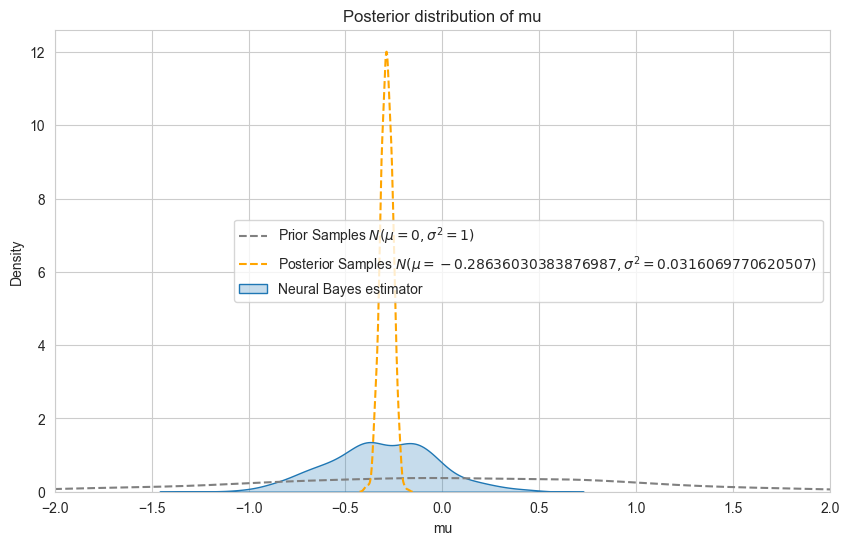

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
mu_prior = 0  # Mean
sigma_prior = 1  # Standard deviation

# Generate samples from the Prior distribution
prior_samples = np.random.normal(loc=mu_prior, scale=sigma_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, label=f"Prior Samples $N(\mu={mu_prior}, \sigma^2={sigma_prior})$", color="grey", linestyle="--")

sigma_poster = np.sqrt(sigma_poster_sq)

# Generate samples from the Posterior distribution
analytic_posterior_samples = np.random.normal(loc=mu_poster, scale=sigma_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(analytic_posterior_samples, ax=ax, label=f"Posterior Samples $N(\mu={mu_poster}, \sigma^2={sigma_poster})$", color="orange", linestyle="--")

# Set x-axis range
ax.set_xlim(-2, 2)


# 参数名称
param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 0], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[0])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[0]}")
plt.legend()
plt.show()

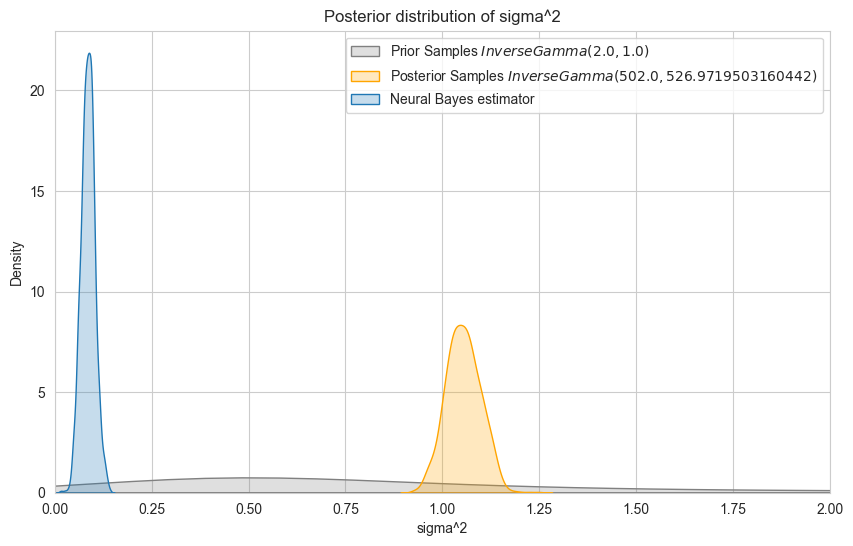

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt


# 创建绘图
fig, ax = plt.subplots(figsize=(10, 6))

num_samples = 1000  # Number of samples

# Set parameters for the Prior distribution
alpha_prior = 2.0  # Shape parameter α
beta_prior = 1.0   # Rate parameter β
# Convert to Inverse Gamma distribution samples
prior_samples = 1 / np.random.gamma(shape=alpha_prior, scale=1 / beta_prior, size=num_samples)

# Plot the KDE for the Prior samples
sns.kdeplot(prior_samples, ax=ax, fill=True, label=f"Prior Samples $InverseGamma({alpha_prior}, {beta_prior})$", color="grey")

# Convert to Inverse Gamma distribution samples for the posterior
analytic_posterior_samples = 1 / np.random.gamma(shape=alpha_poster, scale=1 / beta_poster, size=num_samples)

# Plot the KDE for the Posterior samples
sns.kdeplot(analytic_posterior_samples, ax=ax, fill=True, label=f"Posterior Samples $InverseGamma({alpha_poster}, {beta_poster})$", color="orange")

# Set x-axis range
ax.set_xlim(0, 2)

param_names = ["mu", "sigma^2"]

sns.kdeplot(posterior_samples[:, 1], label="Neural Bayes estimator", fill=True)
plt.xlabel(param_names[1])
plt.ylabel("Density")
plt.title(f"Posterior distribution of {param_names[1]}")
plt.legend()
plt.show()
